In [205]:
%load_ext autoreload
%autoreload 2
from src.models.representation.vae import *
from src.models.representation.vae.vae import RecurrentVaeWithTeacherForcing
from src.models.representation.vae.decoder.recurrent_decoder import LSTMVaeDecoderWithTeacherForcing
from src.dataloader.dataset import PianoRollMidiDataset



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:
import pickle

import torch

dataset: PianoRollMidiDataset = pickle.load(open("data/preprocessed_piano_roll.pkl", "rb"))



In [207]:
from torch.utils.data import DataLoader
encoder = LSTMVaeEncoder(
    60, 
    256,
    128,
    2
)
decoder = LSTMVaeDecoderWithTeacherForcing(
    128, 
    256,
    2,
    60,
    60,
    teacher_forcing_ratio=0.5,
)

vae = RecurrentVaeWithTeacherForcing(encoder, decoder).cuda()


midi_dataloader = DataLoader(
    dataset,
    batch_size=16,
    pin_memory=True,
    num_workers=4,
    shuffle=True,
)


t = next(iter(midi_dataloader))


In [208]:
t.shape

torch.Size([16, 640, 60])

In [209]:
vae(t.cuda())

(tensor([[[ 0.1006, -0.0525,  0.0728,  ..., -0.0836, -0.0918,  0.1241],
          [ 0.0504, -0.0584,  0.0566,  ..., -0.0186, -0.0390,  0.0947],
          [ 0.0160, -0.0534,  0.0508,  ...,  0.0164, -0.0137,  0.0740],
          ...,
          [-0.0070, -0.0500,  0.0587,  ...,  0.0510,  0.0238,  0.0504],
          [-0.0075, -0.0493,  0.0566,  ...,  0.0500,  0.0224,  0.0509],
          [-0.0082, -0.0486,  0.0546,  ...,  0.0481,  0.0212,  0.0514]],
 
         [[-0.1189, -0.1134,  0.2766,  ..., -0.0458,  0.0868, -0.0860],
          [-0.0725, -0.0871,  0.1930,  ...,  0.0188,  0.0472, -0.0229],
          [-0.0413, -0.0748,  0.1348,  ...,  0.0418,  0.0270,  0.0103],
          ...,
          [-0.0088, -0.0456,  0.0553,  ...,  0.0400,  0.0192,  0.0535],
          [-0.0094, -0.0460,  0.0544,  ...,  0.0403,  0.0190,  0.0527],
          [-0.0100, -0.0466,  0.0534,  ...,  0.0406,  0.0188,  0.0521]],
 
         [[ 0.0046, -0.0274,  0.1527,  ...,  0.0483,  0.1029,  0.0463],
          [ 0.0262, -0.0126,

In [210]:
import torch

optimizer = torch.optim.Adam(
    vae.parameters(),
    lr=5*1e-4,
)

loss_fn = VaeLoss(reduction="mean")

trainer = VaeTrainer(
    vae,
    optimizer,
    loss_fn,
    "test/simple_vae",
    10
)

print(t.shape)
trainer.train(midi_dataloader, epochs=10)
trainer.save("test/simple_vae_final.pth")

torch.Size([16, 640, 60])
Epoch [1/10], Loss: 0.0972, Run: test/simple_vae
Epoch [1/10], Loss: 0.0604, Run: test/simple_vae
Epoch [1/10], Loss: 0.0468, Run: test/simple_vae
Epoch [1/10], Loss: 0.0401, Run: test/simple_vae
Epoch [1/10], Loss: 0.0359, Run: test/simple_vae
Epoch [1/10], Loss: 0.0331, Run: test/simple_vae
Epoch [1/10], Loss: 0.0310, Run: test/simple_vae
Epoch [1/10], Loss: 0.0291, Run: test/simple_vae
Epoch [1/10], Loss: 0.0277, Run: test/simple_vae
Epoch [1/10], Loss: 0.0265, Run: test/simple_vae
Epoch [1/10], Loss: 0.0254, Run: test/simple_vae
Epoch [1/10], Loss: 0.0246, Run: test/simple_vae
Epoch [1/10], Loss: 0.0238, Run: test/simple_vae
Epoch [1/10], Loss: 0.0231, Run: test/simple_vae
Epoch [1/10], Loss: 0.0224, Run: test/simple_vae
Epoch [1/10], Loss: 0.0218, Run: test/simple_vae
Epoch [1/10], Loss: 0.0212, Run: test/simple_vae
Epoch [1/10], Loss: 0.0207, Run: test/simple_vae
Epoch [1/10], Loss: 0.0202, Run: test/simple_vae
Epoch [1/10], Loss: 0.0197, Run: test/simpl

KeyboardInterrupt: 

In [211]:
vae.encoder(t[0].unsqueeze(1).cuda())



(tensor([[-0.0248,  0.0115,  0.0160,  ...,  0.0180,  0.0075,  0.0356],
         [-0.0248,  0.0115,  0.0160,  ...,  0.0180,  0.0075,  0.0356],
         [-0.0248,  0.0115,  0.0160,  ...,  0.0180,  0.0075,  0.0356],
         ...,
         [-0.0246,  0.0114,  0.0162,  ...,  0.0181,  0.0073,  0.0356],
         [-0.0246,  0.0114,  0.0162,  ...,  0.0181,  0.0073,  0.0356],
         [-0.0246,  0.0114,  0.0162,  ...,  0.0181,  0.0073,  0.0356]],
        device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[ 0.0085, -0.0079, -0.0192,  ...,  0.0020,  0.0171, -0.0065],
         [ 0.0085, -0.0079, -0.0192,  ...,  0.0020,  0.0171, -0.0065],
         [ 0.0085, -0.0079, -0.0192,  ...,  0.0020,  0.0171, -0.0065],
         ...,
         [ 0.0086, -0.0080, -0.0193,  ...,  0.0019,  0.0170, -0.0065],
         [ 0.0086, -0.0080, -0.0193,  ...,  0.0019,  0.0170, -0.0065],
         [ 0.0086, -0.0080, -0.0193,  ...,  0.0019,  0.0170, -0.0065]],
        device='cuda:0', grad_fn=<AddmmBackward0>))

100%|██████████| 200/200 [01:13<00:00,  2.72it/s]


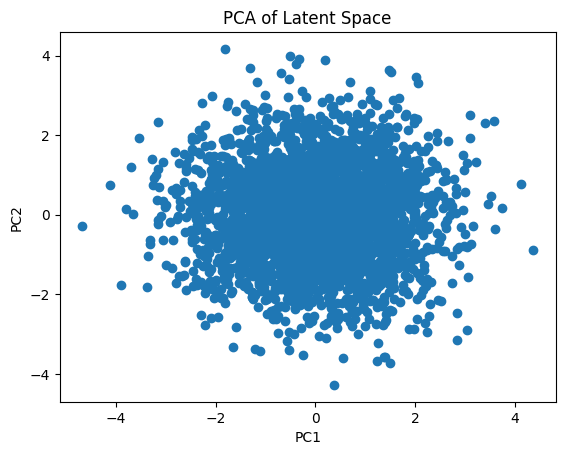

In [212]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm


@torch.inference_mode
def plot_pca(samples: list[tuple[torch.Tensor, torch.Tensor]]):
    all_latents = []
    for mu, logvar in samples:
        reparam = mu + torch.randn_like(logvar) * torch.exp(0.5 * logvar)
        all_latents.append(reparam.cpu().numpy())

    all_latents = np.concatenate(all_latents, axis=0)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(all_latents)

    plt.scatter(reduced[:, 0], reduced[:, 1])
    plt.title("PCA of Latent Space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

vae.eval()
eg_samples = []
for i in tqdm(range(200)):
    t = next(iter(midi_dataloader))
    mu, logvar = vae.encoder(t.cuda())
    eg_samples.append((mu, logvar))

plot_pca(eg_samples)

In [213]:
import pretty_midi

noise = torch.randn(1, 128).cuda()

@torch.inference_mode
def sampler(noise, sqe_length, vae: RecurrentVae):
    """
    Sample from the VAE using the provided noise.
    """
    vae.eval()
    # Encode the noise
    # Decode to get the generated sequence
    generated_sequence = vae.decoder(noise, seq_length=sqe_length)
    return generated_sequence
    
eg_track = sampler(noise, 60, vae)

In [214]:
def print_track_stats(track: torch.Tensor):
    """
    Print statistics of the track.
    """
    scaled = (track * 127.0).clamp(0, 127)
    print(f"Track shape: {track.shape} ")
    print(f"Track min: {track.min()} | scaled min: {scaled.min()}")
    print(f"Track max: {track.max()} | scaled max: {scaled.max()}")
    print(f"Track mean: {track.mean()} | scaled mean: {scaled.mean()}")
    print(f"Track std: {track.std()} | scaled std: {scaled.std()}")
    

print_track_stats(eg_track)


Track shape: torch.Size([1, 60, 60]) 
Track min: -0.10812683403491974 | scaled min: 0.0
Track max: 0.136132150888443 | scaled max: 17.28878402709961
Track mean: 0.0077094449661672115 | scaled mean: 2.699587821960449
Track std: 0.04404206573963165 | scaled std: 3.549131393432617


In [ ]:

def piano_roll_to_pretty_midi(piano_roll, fs=64, path="eg.mid", pitch_range=(24, 84)):
    """
    Convert a piano roll (tensor or array) to a MIDI file using pretty_midi.
    Expects piano_roll to be shape [time, pitch] and in range [0, 1].
    """
    if isinstance(piano_roll, torch.Tensor):
        piano_roll = (piano_roll * 127).clamp(0, 127).detach().cpu().numpy().astype(np.int32)
    
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)
    
    pitch_offset = pitch_range[0]
    time_steps, pitch_count = piano_roll.shape
    
    # Process each pitch to create sustained notes
    for pitch_idx in range(pitch_count):
        pitch = pitch_idx + pitch_offset
        
        # Find note onsets and offsets
        note_on = False
        note_start = 0
        
        for time in range(time_steps):
            velocity = piano_roll[time, pitch_idx]
            
            if velocity > 0 and not note_on:
                # Note starts
                note_on = True
                note_start = time
                note_velocity = int(velocity)
            elif velocity == 0 and note_on:
                # Note ends
                note_on = False
                note = pretty_midi.Note(
                    velocity=note_velocity,
                    pitch=pitch,
                    start=note_start / fs,
                    end=time / fs
                )
                instrument.notes.append(note)
        
        # Handle note that extends to end
        if note_on:
            note = pretty_midi.Note(
                velocity=note_velocity,
                pitch=pitch,
                start=note_start / fs,
                end=time_steps / fs
            )
            instrument.notes.append(note)
    
    pm.instruments.append(instrument)
    pm.write(path)

piano_roll_to_pretty_midi(eg_track[0], path="eg.mid")

In [216]:

track_reco, _, _ = vae(t.cuda())
piano_roll_to_pretty_midi(track_reco[0], path="reco.mid")

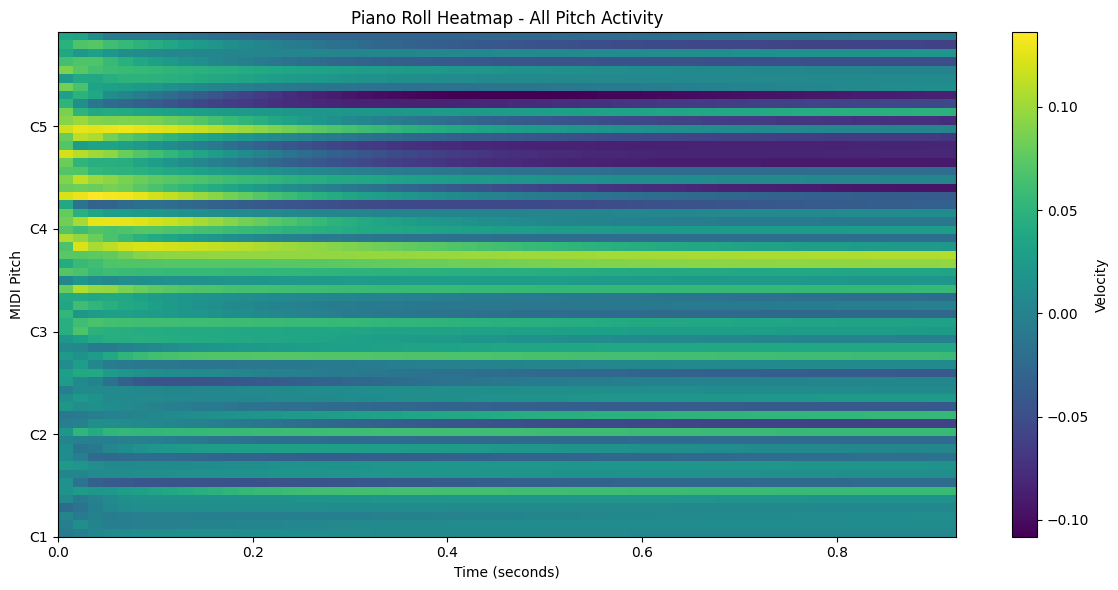

Pitch Movement Analysis:
Average pitch: -16.47
Pitch range: -1108.79 - 63.79
Average pitch change: 39.09 semitones
Max upward jump: -0.04 semitones
Max downward jump: -794.86 semitones


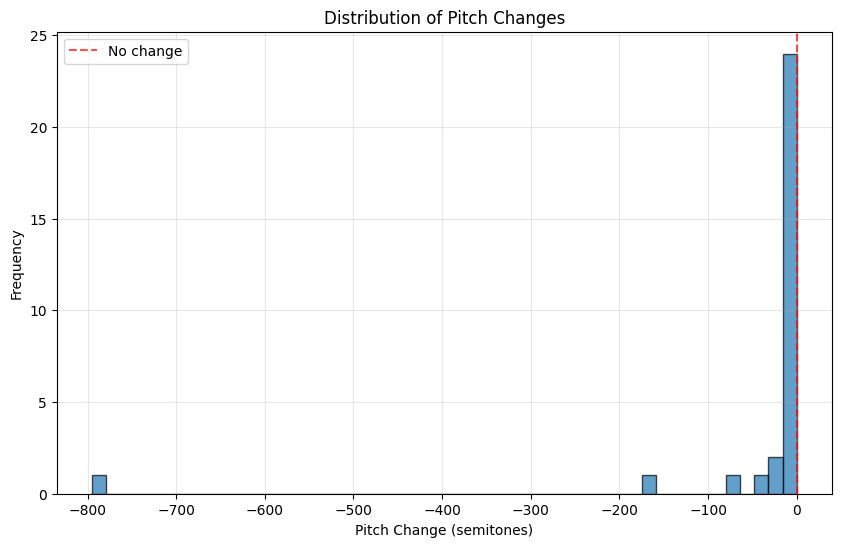

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy import ndimage

def plot_pitch_changes(piano_roll, fs=64, pitch_range=(24, 84), method='heatmap'):
    """
    Plot pitch changes from piano roll data in various ways.
    
    Args:
        piano_roll: Piano roll tensor/array [time, pitch]
        fs: Sample rate (frames per second)
        pitch_range: (min_pitch, max_pitch) MIDI note numbers
        method: 'heatmap', 'dominant', 'centroid', 'active_notes', or 'all'
    """
    if isinstance(piano_roll, torch.Tensor):
        piano_roll = piano_roll.detach().cpu().numpy()
    
    time_steps, pitch_count = piano_roll.shape
    time_axis = np.arange(time_steps) / fs
    pitch_axis = np.arange(pitch_range[0], pitch_range[0] + pitch_count)
    
    if method == 'heatmap' or method == 'all':
        plot_piano_roll_heatmap(piano_roll, time_axis, pitch_axis)
    
    if method == 'dominant' or method == 'all':
        plot_dominant_pitch(piano_roll, time_axis, pitch_axis)
    
    if method == 'centroid' or method == 'all':
        plot_pitch_centroid(piano_roll, time_axis, pitch_axis)
    
    if method == 'active_notes' or method == 'all':
        plot_active_notes(piano_roll, time_axis, pitch_axis)
    
    plt.tight_layout()
    plt.show()

def plot_piano_roll_heatmap(piano_roll, time_axis, pitch_axis):
    """Plot piano roll as a heatmap showing all pitch activity over time."""
    plt.figure(figsize=(12, 6))
    plt.imshow(piano_roll.T, aspect='auto', origin='lower', 
               extent=[time_axis[0], time_axis[-1], pitch_axis[0], pitch_axis[-1]],
               cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Velocity')
    plt.xlabel('Time (seconds)')
    plt.ylabel('MIDI Pitch')
    plt.title('Piano Roll Heatmap - All Pitch Activity')
    
    # Add note names for reference
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave_ticks = [i for i in range(int(pitch_axis[0]), int(pitch_axis[-1]), 12)]
    octave_labels = [f"{note_names[tick % 12]}{tick // 12 - 1}" for tick in octave_ticks]
    plt.yticks(octave_ticks, octave_labels)

def plot_dominant_pitch(piano_roll, time_axis, pitch_axis):
    """Plot the dominant (loudest) pitch at each time step."""
    dominant_pitches = []
    dominant_velocities = []
    
    for t in range(len(time_axis)):
        frame = piano_roll[t, :]
        if np.max(frame) > 0:
            dominant_idx = np.argmax(frame)
            dominant_pitches.append(pitch_axis[dominant_idx])
            dominant_velocities.append(frame[dominant_idx])
        else:
            dominant_pitches.append(np.nan)
            dominant_velocities.append(0)
    
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, dominant_pitches, 'b-', linewidth=2, alpha=0.7)
    plt.xlabel('Time (seconds)')
    plt.ylabel('MIDI Pitch')
    plt.title('Dominant Pitch Over Time')
    plt.grid(True, alpha=0.3)

def plot_pitch_centroid(piano_roll, time_axis, pitch_axis):
    """Plot the pitch centroid (weighted average pitch) over time."""
    centroids = []
    
    for t in range(len(time_axis)):
        frame = piano_roll[t, :]
        if np.sum(frame) > 0:
            # Weighted average pitch
            centroid = np.sum(pitch_axis * frame) / np.sum(frame)
            centroids.append(centroid)
        else:
            centroids.append(np.nan)
    
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, centroids, 'r-', linewidth=2, alpha=0.7)
    plt.xlabel('Time (seconds)')
    plt.ylabel('MIDI Pitch')
    plt.title('Pitch Centroid Over Time (Weighted Average)')
    plt.grid(True, alpha=0.3)

def plot_active_notes(piano_roll, time_axis, pitch_axis, threshold=0.1):
    """Plot all active notes as separate lines over time."""
    plt.figure(figsize=(12, 8))
    
    # Normalize piano roll for better visualization
    piano_roll_norm = piano_roll / np.max(piano_roll) if np.max(piano_roll) > 0 else piano_roll
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(pitch_axis)))
    
    for pitch_idx, pitch in enumerate(pitch_axis):
        activity = piano_roll_norm[:, pitch_idx]
        
        # Only plot pitches that have some activity
        if np.max(activity) > threshold:
            # Create y-values that show note activity
            y_values = np.where(activity > threshold, pitch, np.nan)
            plt.plot(time_axis, y_values, 'o-', color=colors[pitch_idx % len(colors)], 
                    markersize=3, alpha=0.7, linewidth=1)
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('MIDI Pitch')
    plt.title('Active Notes Over Time')
    plt.grid(True, alpha=0.3)

def analyze_pitch_transitions(piano_roll, fs=64, pitch_range=(24, 84)):
    """Analyze pitch transitions and movement patterns."""
    if isinstance(piano_roll, torch.Tensor):
        piano_roll = piano_roll.detach().cpu().numpy()
    
    time_steps, pitch_count = piano_roll.shape
    pitch_axis = np.arange(pitch_range[0], pitch_range[0] + pitch_count)
    
    # Calculate pitch centroids
    centroids = []
    for t in range(time_steps):
        frame = piano_roll[t, :]
        if np.sum(frame) > 0:
            centroid = np.sum(pitch_axis * frame) / np.sum(frame)
            centroids.append(centroid)
        else:
            centroids.append(np.nan)
    
    centroids = np.array(centroids)
    
    # Calculate pitch changes (derivatives)
    valid_mask = ~np.isnan(centroids)
    pitch_changes = np.diff(centroids[valid_mask])
    
    # Statistics
    print("Pitch Movement Analysis:")
    print(f"Average pitch: {np.nanmean(centroids):.2f}")
    print(f"Pitch range: {np.nanmin(centroids):.2f} - {np.nanmax(centroids):.2f}")
    print(f"Average pitch change: {np.mean(np.abs(pitch_changes)):.2f} semitones")
    print(f"Max upward jump: {np.max(pitch_changes):.2f} semitones")
    print(f"Max downward jump: {np.min(pitch_changes):.2f} semitones")
    
    # Plot pitch change histogram
    plt.figure(figsize=(10, 6))
    plt.hist(pitch_changes, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Pitch Change (semitones)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Pitch Changes')
    plt.grid(True, alpha=0.3)
    plt.axvline(0, color='red', linestyle='--', alpha=0.7, label='No change')
    plt.legend()
    plt.show()
    
    return centroids, pitch_changes

plot_pitch_changes(eg_track[0])
centroids, changes = analyze_pitch_transitions(eg_track[0])
